In [1]:
import torch
import matplotlib.pyplot as plt
from random import randint
import cv2
import matplotlib.patches as patches
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
#Pegando as fotos de background
photos = []

for i in os.listdir(os.path.join(os.getcwd(),"Backgrounds")):
    bg = torch.Tensor(cv2.imread(os.path.join(os.getcwd(),"Backgrounds",i)))
    photos.append(bg)
print(len(photos))

15


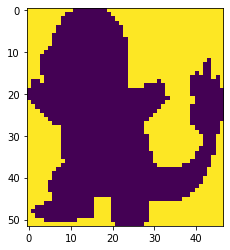

(52, 47, 4)


In [3]:
image = cv2.imread('resized.png', cv2.IMREAD_UNCHANGED)
trans_mask = image[:,:,3]==0
plt.imshow(trans_mask)
plt.show()
print(image.shape)

In [4]:
POKE_DIM = 200
#img_h, img_w,_ = img.shape
#Criando o gerador de fundo preto:

def img_generator(batch_size=16):
    image = cv2.imread('resized.png', cv2.IMREAD_UNCHANGED)
    trans_mask = image[:,:,3] == 0
    image[trans_mask] = [0, 0, 0, 0]
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    img_w,img_h = 0,0
    while True:
        #Batch, Altura, Largura, Colors
        background = torch.zeros((batch_size,POKE_DIM,POKE_DIM,3))
        localization = torch.zeros((batch_size,4))

       
        
        #Criando o gerador de quadrado branco
        for i in range(batch_size):

            #Gerando as fotos com diferentes tamanhos
            scale = randint(50,150)/100
            while img_w<=0 and img_h<=0:
              img_w = int(image.shape[1]*scale)
              img_h = int(image.shape[0]*scale)
            dim = (img_w, img_h)
            image2 = cv2.resize(image, dim, interpolation= cv2.INTER_AREA)

            #Pegando o background aleatório
            bg_idx = randint(0,(len(photos)-1))
            bg = photos[bg_idx]
            bg_h,bg_w,_ = bg.shape

            #Pegando uma posição aleatória do background
            rnd_h = randint(0, (bg_h-POKE_DIM))
            rnd_w = randint(0, (bg_w-POKE_DIM))

            background[i] = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM]
            
            #Rotacionando a foto
            rotate = cv2.getRotationMatrix2D((img_w/2, img_h/2),randint(-90,90),1)
            image2 = cv2.warpAffine(image2, rotate, (img_w,img_h))

            #Inserindo mudança de brilho na foto
            img = torch.tensor(image2)
            img[:,:,:3] = img[:,:,:3]*(randint(50,100)/100)


            #Pegando os pontos do retângulo
            x1 = randint(0,(POKE_DIM-img_w))
            y1 = randint(0,(POKE_DIM-img_h))
            x2 = x1 + img_w
            y2 = y1 + img_h


            mask = (img[:,:,3]==0)#Pega a dimensão Alpha do png (que fala onde está a imagem do pokemon)

            bg_slice = background[i,y1:y2,x1:x2,:]#Cropamos aonde na imagem queremos inserir o pokemon
            bg_slice = mask.unsqueeze(2).expand_as(bg_slice) * bg_slice #Faz multiplicação da máscara pelo background. Onde o pokemon está é 0, logo, vai ficar o background com uma sombra preta!
            bg_slice += img[:,:,:3] #Aqui ele vai inserir as cores de onde o pokemon está.
            background[i,y1:y2,x1:x2,:] = bg_slice #Aqui iremos adicionar a parte cropada na background original
            
            localization[i,0] = x1/POKE_DIM
            localization[i,1] = y1/POKE_DIM
            localization[i,2] = ((x2-x1)/POKE_DIM)*1.1
            localization[i,3] = ((y2-y1-8)/POKE_DIM)*1.1


        yield background/255.,localization

tensor([0.7050, 0.6400, 0.1870, 0.1650])


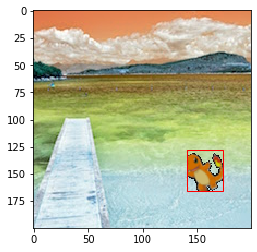

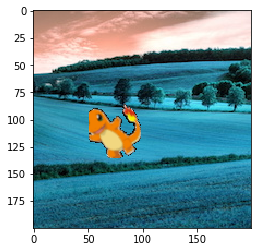

In [112]:
#Instanciando o gerador
generator = img_generator()
valid_generator = img_generator()
for i,j in generator:
    print(j[0])
    fig,ax = plt.subplots(1)
    ax.imshow(i[0])
    rect = patches.Rectangle((j[0,0]*200,j[0,1]*200),j[0,3]*200,j[0,2]*200,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()
    for r,t in valid_generator:
        plt.imshow(r[0])
        plt.show()
       
        break
    break


In [5]:
#Criando a rede neural
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_ftrs, 4), nn.Sigmoid())
model.to(device)
summary(model, input_size=(3, POKE_DIM, POKE_DIM))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]          16,384
      BatchNorm2d-12          [-1, 256, 50, 50]             512
           Conv2d-13          [-1, 256, 50, 50]          16,384
      BatchNorm2d-14          [-1, 256,

In [6]:
from torch.optim import lr_scheduler
#Criando um optimizer para apenas a ÚLTIMA layer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Criando a loss function
loss_function = nn.BCELoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [10]:
import time
import os
from tqdm import tqdm

val_cont = 0
train_loss = 0


val_loss = 0.0
i = 0
l = 0

MODEL_NAME = f"model-{int(time.time())}"
EPOCHS = 20
best = 90000.0
with open("model.log", "a") as f: 
    for epoch in tqdm(range(EPOCHS)):

        i=0
        for data,target in generator:
            data, target = data.to(device), target.to(device)
            #Batch, Colors, Y, X
            data = data.permute(0,3,1,2)
            model.zero_grad()

            output = model(data)
  
            loss = loss_function(output,target)

        
            loss.backward()
            optimizer.step()

            #Estatística da rede neural
            #train_loss += loss.item() * data.size(0)
            i += 1
            if i == 10:
                break
            
        with torch.no_grad():
            for val_data, val_target in valid_generator:
                val_data, val_target = val_data.to(device), val_target.to(device)

                model.zero_grad()
                val_out = model(val_data.permute(0,3,1,2))

                val_loss += loss_function(val_out,val_target).item() * val_data.size(0)


                l += len(val_target)
                break
        v_loss = val_loss / l
        #print(v_loss)
        if v_loss<best:
            best = v_loss
            torch.save(model, os.path.join(os.getcwd(),'model_Charmander.pth'))
        f.write(f"{MODEL_NAME}, {round(time.time(),3)},  {round(float(v_loss),2)}\n")
        exp_lr_scheduler.step()

  0%|          | 0/50 [00:00<?, ?it/s]

 torch.Size([2, 3, 200, 200])



RuntimeError: cuDNN error: CUDNN_STATUS_NOT_SUPPORTED. This error may appear if you passed in a non-contiguous input.

In [5]:
model = torch.load(os.path.join(os.getcwd(), 'model_Charmander.pth'))

model.to(device)
model.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
image = cv2.imread('resized.png', cv2.IMREAD_UNCHANGED)
trans_mask = image[:,:,3] == 0
image[trans_mask] = [0, 0, 0, 0]
image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
img_w,img_h = 0,0
    
background = torch.zeros((POKE_DIM,POKE_DIM,3))

#Gerando as fotos com diferentes tamanhos
scale = randint(50,150)/100
while img_w<=0 and img_h<=0:
  img_w = int(image.shape[1]*scale)
  img_h = int(image.shape[0]*scale)
dim = (img_w, img_h)

image2 = cv2.resize(image, dim, interpolation= cv2.INTER_AREA)

#Pegando o background aleatório
bg_idx = randint(0,(len(photos)-1))
bg = photos[bg_idx]
bg_h,bg_w,_ = bg.shape

#Pegando uma posição aleatória do background
rnd_h = randint(0, (bg_h-POKE_DIM))
rnd_w = randint(0, (bg_w-POKE_DIM))

background = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM]


#Rotacionando a foto
rotate = cv2.getRotationMatrix2D((img_w/2, img_h/2),randint(-90,90),1)
image2 = cv2.warpAffine(image2, rotate, (img_w,img_h))

img = torch.tensor(image2)
img[:,:,:3] = img[:,:,:3]*(randint(50,100)/100)


x1 = randint(0,(POKE_DIM-img_w))
y1 = randint(0,(POKE_DIM-img_h))
x2 = x1 + img_w
y2 = y1 + img_h

mask = (img[:,:,3]==0)#Pega a dimensão Alpha do png (que fala onde está a imagem do pokemon)

bg_slice = background[y1:y2,x1:x2,:]#Cropamos aonde na imagem queremos inserir o pokemon
bg_slice = mask.unsqueeze(2).expand_as(bg_slice) * bg_slice #Faz multiplicação da máscara pelo background. Onde o pokemon está é 0, logo, vai ficar o background com uma sombra preta!
bg_slice += img[:,:,:3] #Aqui ele vai inserir as cores de onde o pokemon está.
background[y1:y2,x1:x2,:] = bg_slice #Aqui iremos adicionar a parte cropada na background original
background = background/255.
input = background.unsqueeze(0).permute(0,3,1,2)

input = input.to(device)
out = model(input)
out = out.reshape(4)
print(f"x1: {x1} y1:{y1} img_w:{img_w} img_h:{img_h}")
print(out)
fig,ax = plt.subplots(1)
ax.imshow(background)
rect = patches.Rectangle((out[0]*200,out[1]*200),out[3]*210,out[2]*210,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

IndexError: too many indices for tensor of dimension 3